<a href="https://colab.research.google.com/github/joshualin24/SelfSupervisedLearning_PyTorch/blob/master/simCLR_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import time
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

torch.manual_seed(1) ### import for reproducibility 

%matplotlib inline

testing simCLR

In [ ]:
print("chech gpu status")
print("CUDA available?", torch.cuda.is_available())

chech gpu status
CUDA available? True


In [ ]:

DOWNLOAD_MNIST = True
train_data = torchvision.datasets.MNIST(
    root='./mnist/', 
    train=True,
    download=DOWNLOAD_MNIST,)

### data loader for processing the data in batch
# train_loader = Data.DataLoader(
#     dataset=train_data, 
#     batch_size=BATCH_SIZE, 
#     shuffle=True)

test_data = torchvision.datasets.MNIST(
    root='./mnist/', train=False)

# !!!!!!!! Change in here !!!!!!!!! #
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000].cuda()/255.   # Tensor on GPU
test_y = test_data.test_labels[:2000].cuda()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.10.0+cu111
DEVICE: cuda


In [ ]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)
    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    
    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

In [ ]:
class CustomDataset(Dataset):
    """Flowers Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = self.list_images[idx]
        image = image / 255
        img = np.zeros((28, 28, 3))
        for i in range(3):
          img[:, :, i] += image

        image = img
        #image = np.expand_dims(image, axis=2)
        #image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image


In [ ]:
print("train", len(train_data.data))

(train_data.data[0].shape)

train 60000


torch.Size([28, 28])

In [ ]:
# The size of the images
output_shape = [28,28]
kernel_size = [3,3] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

mnist_ds = CustomDataset(
    list_images=train_data.data.numpy(),
    transform=custom_transform
)


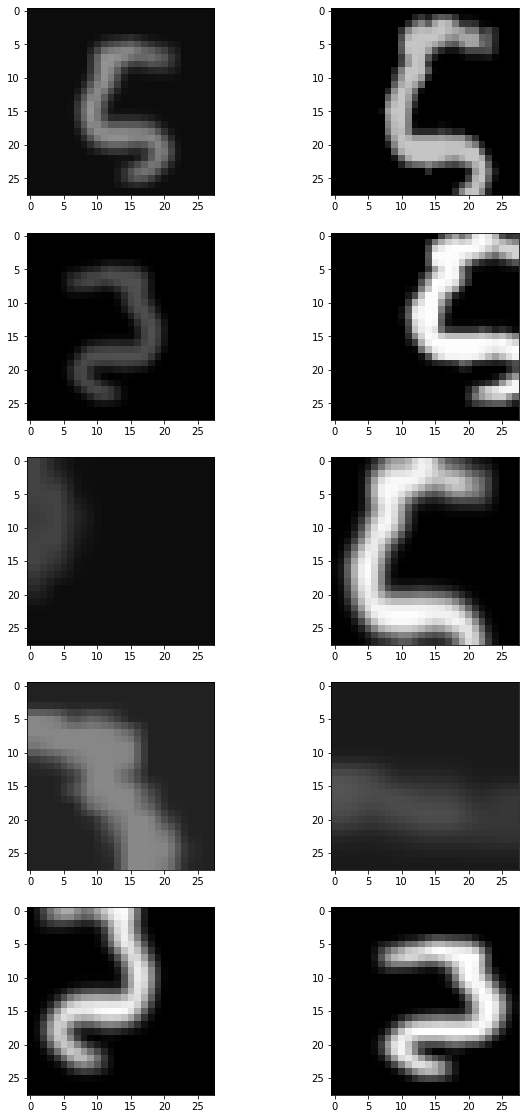

In [ ]:
plt.figure(figsize=(10,20))
def view_data(flowers, index):
    for i in range(1,6):
        images = flowers[index]
        view1, view2 = images
        #print(view1)
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1, 2, 0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1, 2, 0))

view_data(mnist_ds,2000)

In [ ]:
BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    mnist_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        cnn = CNN()
        #resnet18.fc = Identity()
        self.encoder = cnn #resnet18
        self.projection = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1,),                      
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1), 
            nn.ReLU(), 
            nn.MaxPool2d(2, stride=2),)
        self.out = nn.Linear(64 * 7 * 7, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


In [ ]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [ ]:
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters())

In [ ]:

EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(train_dl):
        projections = simclr_model([view.float().to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=2)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 10 LOSS: 0.5534 
EPOCH: 1 BATCH: 20 LOSS: 0.5510 
EPOCH: 1 BATCH: 30 LOSS: 0.5479 
EPOCH: 1 BATCH: 40 LOSS: 0.5453 
EPOCH: 1 BATCH: 50 LOSS: 0.5420 
EPOCH: 1 BATCH: 60 LOSS: 0.5355 
EPOCH: 1 BATCH: 70 LOSS: 0.5320 
EPOCH: 1 BATCH: 80 LOSS: 0.5283 
EPOCH: 1 BATCH: 90 LOSS: 0.5209 
EPOCH: 1 BATCH: 100 LOSS: 0.5193 
EPOCH: 1 BATCH: 110 LOSS: 0.5175 
EPOCH: 1 BATCH: 120 LOSS: 0.5114 
EPOCH: 1 BATCH: 130 LOSS: 0.5066 
EPOCH: 1 BATCH: 140 LOSS: 0.5065 
EPOCH: 1 BATCH: 150 LOSS: 0.4963 
EPOCH: 1 BATCH: 160 LOSS: 0.4982 
EPOCH: 1 BATCH: 170 LOSS: 0.4943 
EPOCH: 1 BATCH: 180 LOSS: 0.4938 
EPOCH: 1 BATCH: 190 LOSS: 0.4935 
EPOCH: 1 BATCH: 200 LOSS: 0.4980 
EPOCH: 1 BATCH: 210 LOSS: 0.4881 
EPOCH: 1 BATCH: 220 LOSS: 0.4802 
EPOCH: 1 BATCH: 230 LOSS: 0.4765 
EPOCH: 1 BATCH: 240 LOSS: 0.4789 
EPOCH: 1 BATCH: 250 LOSS: 0.4788 
EPOCH: 1 BATCH: 260 LOSS: 0.4754 
EPOCH: 1 BATCH: 270 LOSS: 0.4809 
EPOCH: 1 BATCH: 280 LOSS: 0.4729 
EPOCH: 1 BATCH: 290 LOSS: 0.4757 
EPOCH: 1 BATCH: 300 LOS

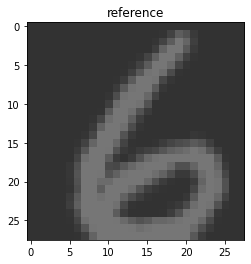

similarity 0.54798687


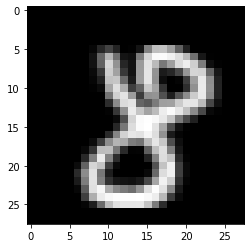

similarity 0.57407975


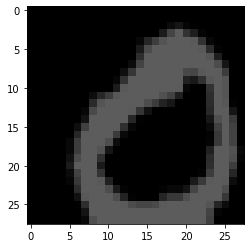

similarity 0.6809287


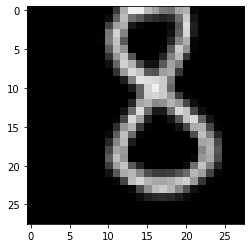

In [ ]:
X_train_feature = []
reference = simclr_model.encoder(views[0].float().cuda()).detach().cpu().numpy()[0]
reference = reference/ np.linalg.norm(reference)

plt.imshow(views[0][0].permute(1, 2, 0))
plt.title("reference")
plt.show()




for i, views in enumerate(train_dl):
  representation = simclr_model.encoder(views[0].float().cuda())
  representation = representation.detach().cpu().numpy()[0]
  X_train_feature.append(representation)
  representation = representation / np.linalg.norm(representation)
    #print("sum", sum(representation**2))
  similarity = np.dot(reference, representation)
  #print(similarity)
  if similarity > 0.5:
      print('similarity', similarity)
  #print("representation", representation)
  #print("sum", sum(representation**2))
      plt.imshow(views[0][0].permute(1, 2, 0))
      plt.show()
  if i == 20:
    break

In [ ]:
print("here")

mnist_test_ds = CustomDataset(
    list_images=test_data.data.numpy(),
    transform=custom_transform
)


here


In [ ]:
BATCH_SIZE = 1

# Building the data loader
test_dl = torch.utils.data.DataLoader(
    mnist_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


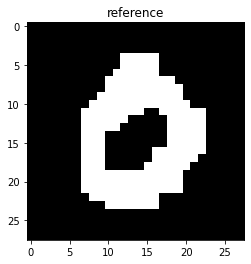

similarity 0.6014383


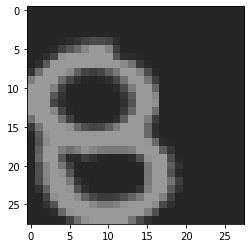

similarity 0.8062172


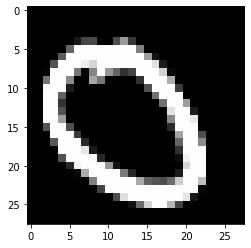

similarity 0.6804739


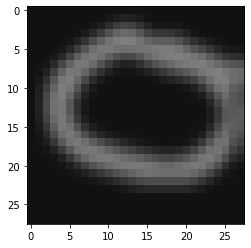

similarity 0.6051091


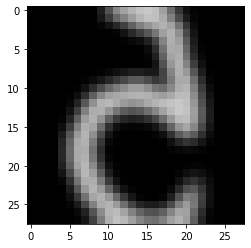

In [ ]:
ref_idx = 3
sample_image = torch.zeros((1, 3, 28, 28))

for i in range(3):
    sample_image[0, i, :, :] += test_data.data[ref_idx]

reference = simclr_model.encoder(sample_image.float().cuda()).detach().cpu().numpy()[0]
reference = reference/ np.linalg.norm(reference)

plt.imshow(sample_image[0].permute(1, 2, 0))
plt.title("reference")
plt.show()




for i, views in enumerate(test_dl):
  representation = simclr_model.encoder(views[0].float().cuda())
  representation = representation.detach().cpu().numpy()[0]
  X_train_feature.append(representation)
  representation = representation / np.linalg.norm(representation)
    #print("sum", sum(representation**2))
  similarity = np.dot(reference, representation)
  #print(similarity)
  if similarity > 0.6:
      print('similarity', similarity)
  #print("representation", representation)
  #print("sum", sum(representation**2))
      plt.imshow(views[0][0].permute(1, 2, 0))
      plt.show()
  if i == 100:

    break